In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from utils.DiceLoss import DiceLoss
from utils.JaccardIndex import JaccardIndex
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import blob_doh, blob_log
from skimage.morphology import dilation, square
from skimage.measure import label, regionprops
import math
import sys

from utils.function_lib import *
from utils.LiverDataset import *
from utils.DiceLoss import *
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn_image as isns
from skimage.transform import resize

In [4]:
models = ['DenseNet201', 'Inception', 'ResNet152', 'ResNeXt101', 'Fusion']
seg_proc = np.zeros((len(models), 1507, 256, 256), dtype=bool)
# Incarcare imagini presegmentate
seg_folder = 'G:/MachineLearning/lesion-database/validation/'

for i in range(len(models)):
    full_path = seg_folder + models[i]
    seg_files = glob.glob(full_path + '/*.ct')
    for j in range(len(seg_files)):
        seg_proc[i, j, :, :] = np.fromfile(seg_files[j], dtype=np.int8).squeeze().reshape([256, 256]).astype(bool)
    print(f"Done loading {models[i]} post-processed")

seg_proc = torch.tensor(seg_proc)

# Incarcare ground truth
lits_seg = glob.glob('G:/MachineLearning/lesion-database/validation/masks/*.ct')
ground_truth = np.zeros((1507, 256, 256), dtype=bool)
for j in range(len(lits_seg)):
    ground_truth[j, :, :] = np.fromfile(lits_seg[j], dtype=np.float16).squeeze().reshape([256, 256]).astype(bool)
print(f"Done loading ground truth")
ground_truth = torch.tensor(ground_truth)

ct_files = glob.glob('G:/MachineLearning/lesion-database/validation/images/*.ct')
ct = np.zeros((1507, 256, 256), dtype=np.float)
for j in range(len(ct_files)):
    ct[j, :, :] = np.fromfile(ct_files[j], dtype=np.float16).squeeze().reshape([256, 256])
print(f"Done loading CT images")
ct = torch.tensor(ct)

Done loading DenseNet201 post-processed
Done loading Inception post-processed
Done loading ResNet152 post-processed
Done loading ResNeXt101 post-processed
Done loading Fusion post-processed
Done loading ground truth


C:\Users\Stanciu\anaconda3\envs\MLEnv\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Done loading CT images


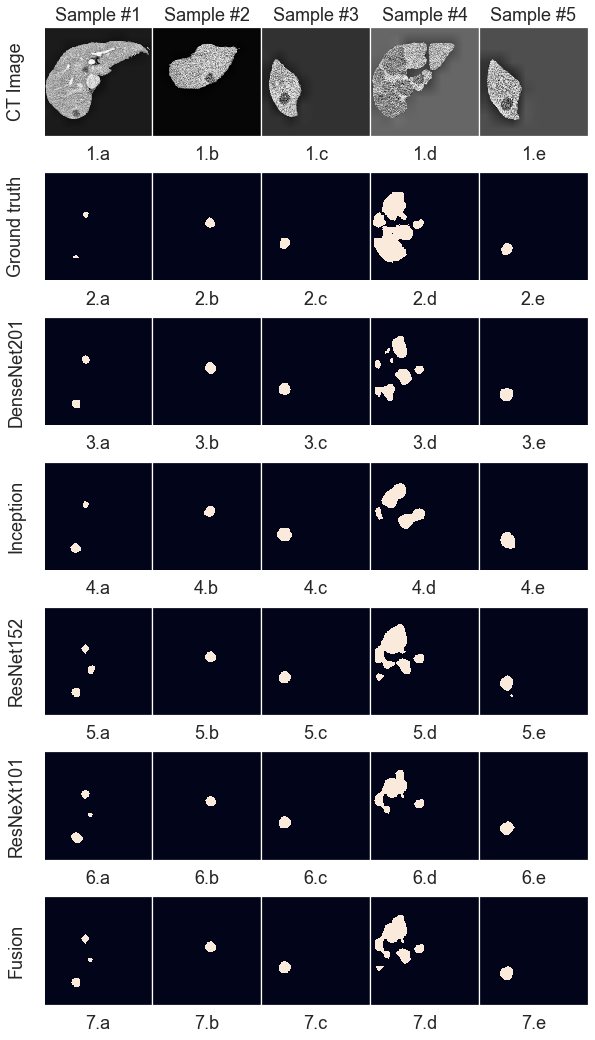

In [11]:
diff = 0
samples = np.array([45, 182, 1379, 483, 1200]) + diff

ncols = len(samples)

fig = plt.figure(figsize=(12, 18))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(7, ncols),
                    axes_pad=(0.0, 0.5),
                    label_mode='all',
                    )
for idx, ax in enumerate(grid):
    if idx // ncols == 0:
        ax.imshow(np.transpose(1 - ct[samples[idx % ncols], :, :]), cmap="Greys")
        if idx % ncols == 0:
            ax.set_ylabel("CT Image")
        ax.set_xlabel(str(idx // ncols + 1) + "." + chr(ord('a')+idx % ncols), labelpad=-15)
        ax.set_xticks([0], [' '])
        ax.set_yticks([0], [' '])
        ax.set_title(f"Sample #{idx % ncols + 1}")

    elif idx // ncols == 1:
        ax.imshow(np.transpose(ground_truth[samples[idx % ncols], :, :]))
        ax.set_xlabel(str(idx // ncols + 1) + "." + chr(ord('a')+idx % ncols), labelpad=-15)
        ax.set_xticks([0], [' '])
        ax.set_yticks([0], [' '])
        if idx % ncols == 0:
            ax.set_ylabel("Ground truth")
    else:
        ax.imshow(np.transpose(seg_proc[idx//ncols - 2, samples[idx % ncols], :, :]))
        ax.set_xlabel(str(idx // ncols + 1) + "." + chr(ord('a')+idx % ncols), labelpad=-15)
        ax.set_xticks([0], [' '])
        ax.set_yticks([0], [' '])
        if idx % ncols == 0:
            ax.set_ylabel(models[idx//ncols - 2])

plt.yticks(rotation=0)

sns.set(font_scale=1.5)
plt.grid(False)
plt.show()


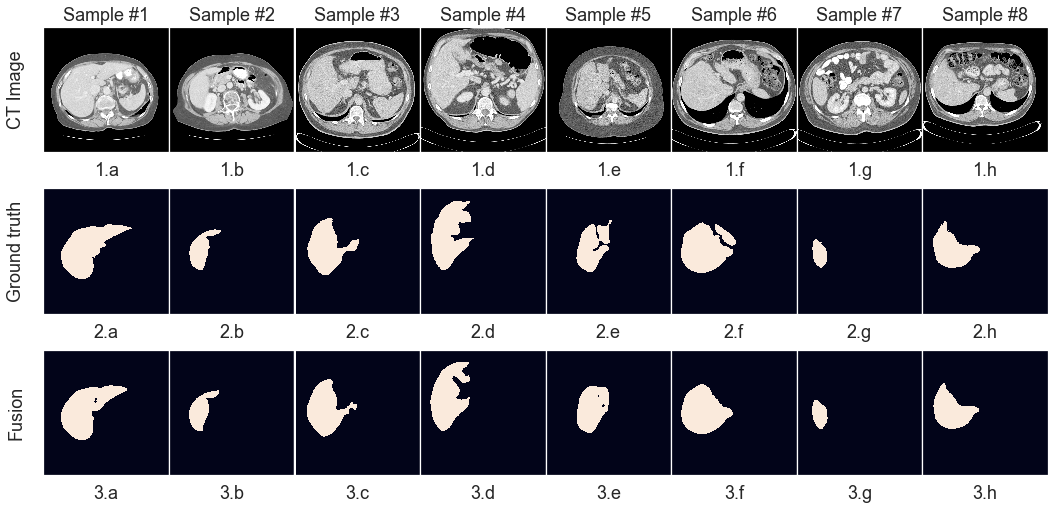

In [11]:
diff = 0
samples = np.array([60, 50,  583, 1118, 2500, 3601, 3500, 4677]) + diff

ncols = len(samples)

fig = plt.figure(figsize=(18, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, ncols),
                 axes_pad=(0.0, 0.5),
                 label_mode='all',
                 )
for idx, ax in enumerate(grid):
    if idx // ncols == 0:
        ax.imshow(np.transpose(1 - ct[samples[idx % ncols], :, :]), cmap="Greys")
        if idx % ncols == 0:
            ax.set_ylabel("CT Image")
        ax.set_xlabel(str(idx // ncols + 1) + "." + chr(ord('a')+idx % ncols), labelpad=-15)
        ax.set_xticks([0], [' '])
        ax.set_yticks([0], [' '])
        ax.set_title(f"Sample #{idx % ncols + 1}")

    elif idx // ncols == 1:
        ax.imshow(np.transpose(ground_truth[samples[idx % ncols], :, :]))
        ax.set_xlabel(str(idx // ncols + 1) + "." + chr(ord('a')+idx % ncols), labelpad=-15)
        ax.set_xticks([0], [' '])
        ax.set_yticks([0], [' '])
        if idx % ncols == 0:
            ax.set_ylabel("Ground truth")
    else:
        ax.imshow(np.transpose(seg_proc[idx//ncols - 2 + 4, samples[idx % ncols], :, :])) # afisam fusion
        ax.set_xlabel(str(idx // ncols + 1) + "." + chr(ord('a')+idx % ncols), labelpad=-15)
        ax.set_xticks([0], [' '])
        ax.set_yticks([0], [' '])
        if idx % ncols == 0:
            ax.set_ylabel(models[idx//ncols - 2 + 4])

plt.yticks(rotation=0)

sns.set(font_scale=1.5)
plt.grid(False)
plt.show()